In [1]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.Alphabet import IUPAC

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("whitegrid")

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.utils.multiclass import unique_labels

import pickle

import shap

In [20]:
shap.initjs()

In [11]:
def get_data(pickle_seqdf, pickle_ohe):
    ohe_df = pd.read_pickle(pickle_ohe)
    seq_df = pd.read_pickle(pickle_seqdf)

    # Select only callithrix samples
    ohe_df_calli = ohe_df[ohe_df['Host'] == 'Callithrix']
    ohe_df_calli = ohe_df_calli.sort_values(by='Ct_Group')

    # Select alouatta samples for comparison later
    ohe_df_alou = ohe_df[ohe_df['Host'] == 'Alouatta']
    ohe_df_alou = ohe_df_alou.sort_values(by='Ct_Group')

    return (seq_df, ohe_df, ohe_df_calli, ohe_df_alou)

In [14]:
def get_train_test_split(ohe_df_calli, test_size=0.1):
    # Get only the ohe nucleotide info in X
    X = ohe_df_calli.drop(["ID","Host","Ct","Date","Season","Ct_Group"], axis=1)
    # The target class is Ct_Group (high or low)
    y = ohe_df_calli["Ct_Group"]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=0,
                                                        shuffle=True,
                                                        stratify=y)

    ## Dealing with imbalanced data
    scale_pos_weight = len(y_train)/y_train.sum()

    return (X, y, X_train, X_test, y_train, y_test, scale_pos_weight)

# Import data
The explainers and their respective SHAP values were generated on `MAIN_CALLITHRIX_YFV_rev1.py`

In [10]:
pickle_ohe = '../DATA/Callithrix_Analysis/DATA/!CLEAN/YFV_seq_ohe_df.pkl'
pickle_seqdf = '../DATA/Callithrix_Analysis/DATA/!CLEAN/YFV_seq_df.pkl'

In [12]:
(seq_df, ohe_df, ohe_df_calli, ohe_df_alou) = get_data(pickle_seqdf, pickle_ohe)

In [13]:
ohe_df_calli['Ct_Group'] = ohe_df_calli['Ct_Group'].astype(int)

In [15]:
(X, y, X_train, X_test, y_train, y_test, scale_pos_weight) = get_train_test_split(ohe_df_calli, test_size=0.1)

In [5]:
xgb_explainer = pickle.load(open("./OUTPUT/CAL_xgb_explainer.pickle.dat", "rb"))

In [6]:
rf_explainer = pickle.load(open("./OUTPUT/CAL_rf_explainer.pickle.dat", "rb"))

In [7]:
xgb_shap_values = pickle.load(open("./OUTPUT/CAL_xgb_shap_values.pickle.dat", "rb"))

In [8]:
rf_shap_values = pickle.load(open("./OUTPUT/CAL_rf_shap_values.pickle.dat", "rb"))

In [43]:
# Inverted the signal to be consistent with XGBoost values.
# This happened because the original explainer generates 2 matrices, one for each class, and I imported the negative one.

rf_shap_values = rf_shap_values * (-1)

# Visualization

In [21]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(xgb_explainer.expected_value, xgb_shap_values[0,:], X.iloc[0,:])

In [22]:
# visualize the training set predictions
shap.force_plot(xgb_explainer.expected_value, xgb_shap_values, X)

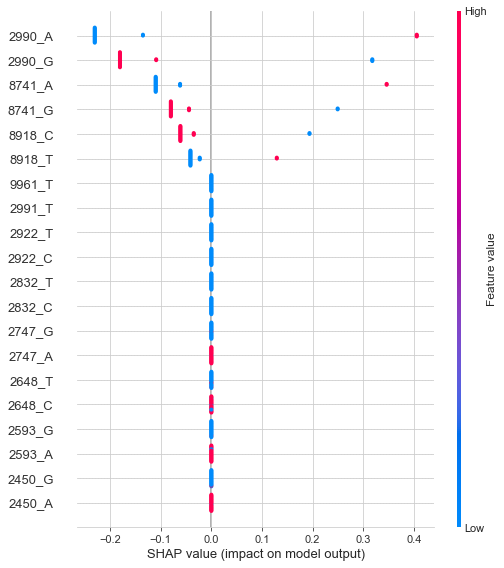

In [23]:
# summarize the effects of all the features
shap.summary_plot(xgb_shap_values, X)

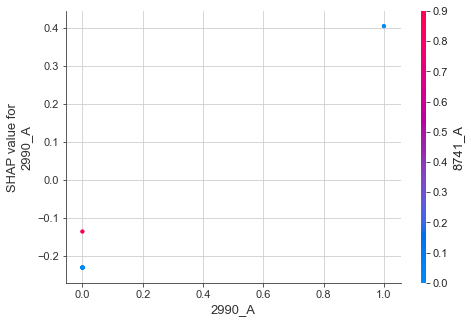

In [26]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("2990_A", xgb_shap_values, X)

In [44]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(rf_explainer.expected_value[0], rf_shap_values[0,:], X.iloc[0,:])

In [45]:
# visualize the training set predictions
shap.force_plot(rf_explainer.expected_value[0], rf_shap_values, X)

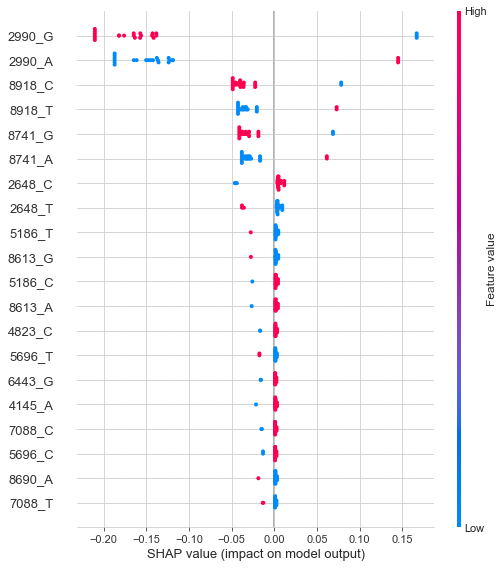

In [46]:
# summarize the effects of all the features
shap.summary_plot(rf_shap_values, X)

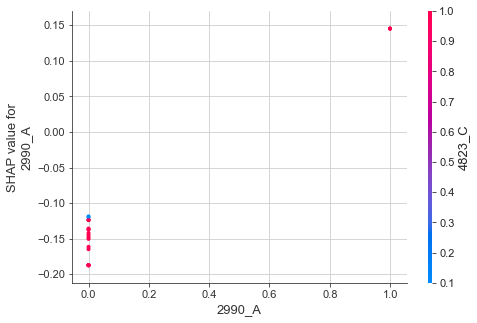

In [48]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("2990_A", rf_shap_values, X)